In [8]:
import torch
import torch.nn as nn
import numpy as np
import time
from function import fun1,fun2,fun3,fun4,fun5,fun6
from my_NN import Mynetwork
import os
import matplotlib.pyplot as plt

# 确保 model 文件夹存在
os.makedirs('./model_parameter', exist_ok=True)

debug=False

In [9]:
def sample_t_per_interval_and_generate_f_start(dtype,device,seg_step=16,batch_size=32,f_start_min=0.1,f_start_max=0.9):
    t_seg=torch.linspace(0,1,seg_step+1,dtype=dtype,device=device)
    t_seg=t_seg.repeat(batch_size,1)
    
    rand_move=torch.empty((batch_size,seg_step+1),dtype=dtype,device=device).uniform_(-0.2/seg_step,0.2/seg_step)
    rand_move[:,0]=0
    rand_move[:,-1]=0
    
    t_seg+=rand_move
    
    f_start_rand=torch.empty((batch_size,1),dtype=dtype,device=device).uniform_(f_start_min,f_start_max)
    
    return t_seg , f_start_rand


In [10]:
def boundary_loss_calculator(model,t_seg,f_start_rand,seg_step,loss_func,batch_size,boundary_func=fun1,f_start_min=0.1,f_start_max=0.9):
    #注意这里t_seg还是size为(batch_size,seg_step+1)的tensor
    t_seg_copy=t_seg.clone()
    t_seg_copy=t_seg_copy.unsqueeze_(-1)
    
    log_step=int(np.log2(seg_step))
    
    delta=t_seg_copy[:,1:]-t_seg_copy[:,:-1]
    func_f_end_value=boundary_func(f_start_rand)
    
    model_f_end_value=f_start_rand
    for i in range(seg_step):
        model_f_end_value=model_f_end_value + delta[:,i] * model.forward(model_f_end_value,t_seg_copy[:,i],delta[:,i])
    
    boundary_loss=loss_func(model_f_end_value,func_f_end_value)    
    #####
    temp_step=seg_step
    
    for i in range(log_step):
        t_seg_copy=t_seg_copy[:,::2]
        temp_step=temp_step//2
        delta=t_seg_copy[:,1:]-t_seg_copy[:,:-1]
        model_f_end_value=f_start_rand
        for i in range(temp_step):
            model_f_end_value=model_f_end_value + delta[:,i] * model.forward(model_f_end_value,t_seg_copy[:,i],delta[:,i])
        boundary_loss+=loss_func(model_f_end_value,func_f_end_value)
    
    
    return boundary_loss/log_step
    

In [11]:
def get_loss(model,loss_func,batch_size,seg_step,dtype,device,boundary_func=fun1,f_start_min=0.1,f_start_max=0.6,consist_depth=5):
    use_consist_loss=False
    
    t_seg,f_start_rand=sample_t_per_interval_and_generate_f_start(dtype=dtype,device=device,seg_step=seg_step,batch_size=batch_size,f_start_min=f_start_min,f_start_max=f_start_max)
    
    boundary_loss=boundary_loss_calculator(model,t_seg,f_start_rand,seg_step,loss_func,batch_size,boundary_func=boundary_func,f_start_min=f_start_min,f_start_max=f_start_max)
    
    if debug:
        print('boundary_loss:',boundary_loss)
    loss=boundary_loss
    
    return loss
    

In [12]:
def iteration(model,optimizer,loss_func,device,dtype,batch_size,consist_depth=5,boundary_func=fun1):
    #train_loop
    optimizer.zero_grad()
    #计算loss
    #这里可以调节seg_step，f_start_min,f_start_max
    loss=get_loss(model,loss_func,batch_size,seg_step=64,dtype=dtype,device=device,boundary_func=boundary_func,consist_depth=consist_depth,f_start_min=0.1,f_start_max=0.9)
    #反向传播
    loss.backward()
    #更新参数
    optimizer.step()
    return loss.item()

In [13]:
def training(model,device='cuda',dtype=torch.float32,
          epoch=100,batch_size=32,lr=0.01,consist_depth=5,
          use_lr_scheduler=False,boundary_func=fun1):
    loss_list = []
    
    loss_func = nn.MSELoss()
    model.train()
    optimizer = torch.optim.Adam(params=model.parameters(),
                                 lr=lr,
                                 **({"fused": True} if "cuda" in str(device) else {}))#这里的fused=True，是为了使用apex加速

    # Use ReduceLROnPlateau as the learning rate scheduler
    if use_lr_scheduler:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                               patience=60,
                                                               threshold=1e-4,
                                                               cooldown=3)
    
    init_time = time.time()
    for i in range(epoch):
        loss_term=iteration(model,optimizer,loss_func,device,dtype,batch_size,consist_depth=consist_depth,boundary_func=boundary_func)
        #设计中，iteration中已经完成反向传播，所以这里不需要再进行反向传播
        loss_list.append(loss_term)
        if (i+1)%20==0:
            print(f'epoch:{i+1},loss:{loss_term},time:{time.time()-init_time},lr:{optimizer.param_groups[0]["lr"]}')
        if (i+1)%50==0:
            torch.save(model.state_dict(),f'./model_parameter/batch{batch_size}_epoch{epoch}.pth')
        if use_lr_scheduler:
            scheduler.step(loss_term)
        if optimizer.param_groups[0]["lr"] <= 1.1e-8:
            break
    print('terminal epoch: ',i+1)
    
    if debug==False:
        plt.plot(loss_list,label='loss')
        plt.legend()
    pass

now using cuda !
epoch:20,loss:0.7063724994659424,time:1.4741666316986084,lr:0.001
epoch:40,loss:0.30004674196243286,time:2.841055154800415,lr:0.001
epoch:60,loss:0.09251552820205688,time:4.3432371616363525,lr:0.001
epoch:80,loss:0.08975609391927719,time:5.807168483734131,lr:0.001
epoch:100,loss:0.07368161529302597,time:7.276902675628662,lr:0.001
epoch:120,loss:0.06767340749502182,time:8.753251314163208,lr:0.001
epoch:140,loss:0.053969889879226685,time:10.225582838058472,lr:0.001
epoch:160,loss:0.038197003304958344,time:11.703700542449951,lr:0.001
epoch:180,loss:0.026532869786024094,time:13.125192642211914,lr:0.001
epoch:200,loss:0.01674191653728485,time:14.6292405128479,lr:0.001
epoch:220,loss:0.011036543175578117,time:16.165318727493286,lr:0.001
epoch:240,loss:0.008155846036970615,time:17.673131942749023,lr:0.001
epoch:260,loss:0.006582863628864288,time:19.19524097442627,lr:0.001
epoch:280,loss:0.00585669931024313,time:20.70937943458557,lr:0.001
epoch:300,loss:0.004599694162607193,ti

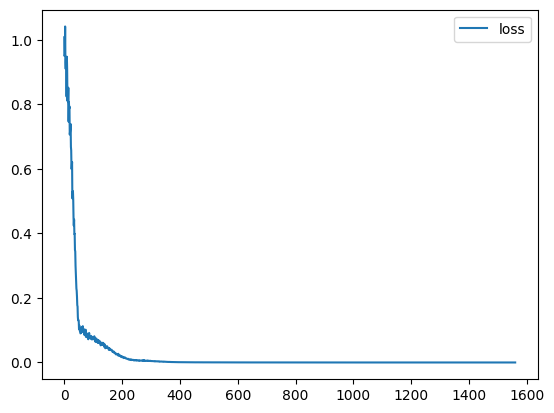

In [ ]:
if __name__=='__main__':
    initial_time=time.time()
    if torch.cuda.is_available():
        device='cuda'
        print('now using cuda !')
    else:
        device='cpu'
        print('now using cpu !')
    dtype=torch.float32
    model=Mynetwork().to(device=device,dtype=dtype)
    #初始化网络参数
    from torch.nn import init
    for name, param in model.named_parameters():
        if 'weight' in name:
            init.normal_(param, mean=0, std=0.1)
        elif 'bias' in name:
            init.constant_(param, val=0)
            
    ############################################################
    #设置超参数
    batch_size=256
    epoch=10000
    if debug:epoch=1
    consist_depth=5
    #training part 
    training(model,device,dtype,epoch=epoch,lr=0.001,batch_size=batch_size,consist_depth=consist_depth,use_lr_scheduler=True,boundary_func=fun1)
    
    print('program ended here \n terminal time: ', time.time()-initial_time)
    print(f'save model parameter in file name : model_para_batch{batch_size}_epoch{epoch}_consist_depth{consist_depth}.pth')